In [2]:
# Script import setup
import numpy as np
import matplotlib.pyplot as plt
from gfm.base import GFMSolver
from gfm.util import setFig, getLastPlotCol
plt.rcParams['figure.dpi'] = 100

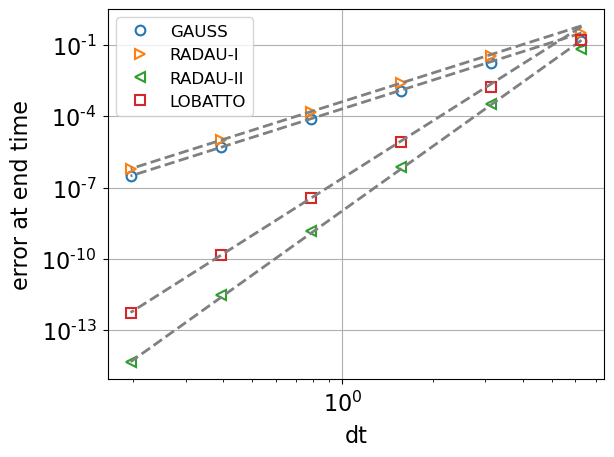

In [130]:
def getCollocationError(M, qType, nodes, T=2*np.pi, lam=1j):
    err = []
    lDt = []
    for l in [1, 2, 4, 8, 16, 32]:
        # Compute time step size
        dt = T/l
        lDt.append(dt)
        # Set the collocation solver up
        solver = GFMSolver(lam=lam, u0=1, dt=dt, L=l)
        solver.setFineLevel(M=M, method='COLLOCATION', qType=qType, nodes=nodes)
        # Extract H matrix to extrapolate the end point (for LOBATTO and RADAU-II, just a copy)
        H = solver.chi
        # Compute end time solution for collocation
        uEndNum = (H @ solver.uFine[-1])[0]
        # Compute end time exact solution
        uEndExact = np.exp(T*lam)
        # Store error
        err.append(abs(uEndExact-uEndNum))
    return err, lDt, solver

nodes = 'LEGENDRE'
M = 5
for qType, order, sym in zip(['GAUSS', 'RADAU-I', 'RADAU-II', 'LOBATTO'], 
                             [M-1, M-1, 2*M-1, 2*M-2],
                             ['o', '>', '<', 's']):
    err, lDt, solver = getCollocationError(M=M, qType=qType, nodes=nodes)
    plt.loglog(lDt, err, sym, label=qType)
    lDt = np.array(lDt)
    c = err[-1]/lDt[-1]**order
    plt.plot(lDt, c*lDt**order, '--', color='gray')

plt.legend()
plt.xlabel('dt')
plt.ylabel('error at end time')
plt.grid()


In [102]:
solver.chi

array([[ 0.18783611, -0.66666667,  1.47883056],
       [ 0.18783611, -0.66666667,  1.47883056],
       [ 0.18783611, -0.66666667,  1.47883056]])